## Example 24: CONLIN 
The volume of a four-bar truss should be minimized under the displacement constraint $\delta \le \delta_0$. There is a force $P>0$ and all bars have identical lengths $l$ and identical Young's moduli $E$. The modifiable structural variables are the cross sectional areas $A_1=A_4$ and $A_2=A_3$. We define $A_0 = Pl / (10\delta_0E)$ and constrain the variables $0.2A_0 \le A_j \le 2.5 A_0$. Then we can use dimensionless design variables $a_1=A_1/A_0 \in [0.2, 2.5]$ and $a_2=A_2/A_0 \in [0.2, 2.5]$.

![Four bar truss](../figures/four_bar_truss.png)

The optimization problem is 
$$ \min_{\mathbf{a}}    \quad  f(\mathbf{a})= a_1 + a_2 $$
$$ \textrm{s.t.}        \quad  g(\mathbf{a}) = \frac{8}{16a_1+9a_2} - \frac{4.5}{9a_1+16a_2} -0.1 \le 0  $$
$$                      \quad  \mathbf{a} \in [0.2,2.5]^2$$

Credits: Peter W. Christensen and Anders Klarbring. *An Introduction to Structural Optimization.* Springer Netherlands, 2008.

In [1]:
import torch
import matplotlib.pyplot as plt
from torchfem.utils import plot_contours

plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 14
torch.set_default_dtype(torch.double)

In [2]:
# Define f(a)
def f(a):
    return a[..., 0] + a[..., 1]


# Define g(a)
def g(a):
    return (
        8 / (16 * a[..., 0] + 9 * a[..., 1])
        - 4.5 / (9 * a[..., 0] + 16 * a[..., 1])
        - 0.1
    )

In [3]:
# Define domain
a_1 = torch.linspace(0.0, 3.0, 200)
a_2 = torch.linspace(0.0, 3.0, 200)
a = torch.stack(torch.meshgrid(a_1, a_2, indexing="xy"), dim=2)
a_lower = torch.tensor([0.2, 0.2])
a_upper = torch.tensor([2.5, 2.5])

[]

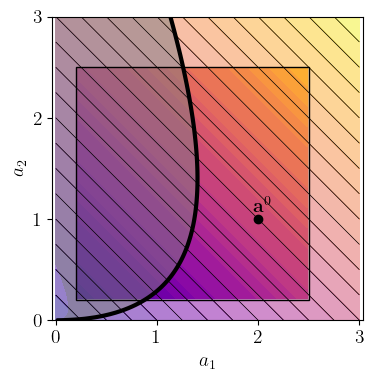

In [9]:
a0 = torch.tensor([2.0, 1.0])

# Base plot
plot_contours(a, f(a), figsize=(4.0, 4.0), box=[a_lower, a_upper])

# Original constraint
plt.contour(a_1, a_2, g(a), [0], colors="k", linewidths=3)
plt.contourf(a_1, a_2, g(a), [0, 1], colors="gray", alpha=0.5)

# Points
plt.plot([a0[0]], [a0[1]], "o", color="black")
plt.annotate("$\mathbf{a}^0$", (1.95, 1.07), color="black")

# Styling
plt.xlabel("$a_1$")
plt.ylabel("$a_2$")
plt.xticks([0, 1, 2, 3])
plt.yticks([0, 1, 2, 3])
plt.tight_layout()
plt.savefig("../figures/four_bar_example.svg", transparent=True)
plt.plot()

The CONLIN approximation of the objective function is the objective function itself - it is already linear. A CONLIN approximation of the constraint function at $\mathbf{a}^0=(2,1)^\top$ is computed using automatic differentiation in PyTorch and results in the dashed black line. The resulting problem is convex and can be solved, e.g. using Lagrangian duality. The unique solution of this problem is the point $\mathbf{a}^1=(1.2,0.2)^\top$.

In [5]:
# Define the CONLIN approximation
def CONLIN(func, a_k, a):
    a_lin = a_k.clone().requires_grad_()
    grads = torch.autograd.grad(func(a_lin).sum(), a_lin)[0]
    res = func(a_k) * torch.ones_like(a[..., 0])
    for i, grad in enumerate(grads):
        if grad < 0:
            gamma = a_k[i] / a[..., i]
        else:
            gamma = 1
        res += grad * gamma * (a[..., i] - a_k[i])
    return res

[]

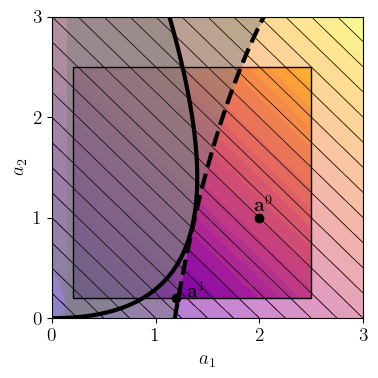

In [6]:
a1 = torch.tensor([1.2, 0.2])
g_0 = CONLIN(g, a0, a)

# Base plot
plot_contours(a, f(a), figsize=(4.0, 4.0), box=[a_lower, a_upper])

# Original constraint
plt.contour(a_1, a_2, g(a), [0], colors="k", linewidths=3)
plt.contourf(a_1, a_2, g(a), [0, 1], colors="gray", alpha=0.5)

# Approximated constraint
plt.contour(a_1, a_2, g_0, [0], colors="k", linewidths=3, linestyles="--")
plt.contourf(a_1, a_2, g_0, [0, 1], colors="gray", alpha=0.5)

# Points
plt.plot([a0[0]], [a0[1]], "o", color="black")
plt.annotate("$\mathbf{a}^0$", (1.95, 1.07), color="black")
plt.plot([a1[0]], [a1[1]], "o", color="black")
plt.annotate("$\mathbf{a}^1$", (1.3, 0.21), color="black")

# Styling
plt.xlabel("$a_1$")
plt.ylabel("$a_2$")
plt.xticks([0, 1, 2, 3])
plt.yticks([0, 1, 2, 3])
plt.tight_layout()
plt.savefig("../figures/four_bar_example_0.svg", transparent=True)
plt.plot()

We can apply the CONLIN method again at this point to obtain a new convex problem. Solving this problem gives $\mathbf{x}^2=(0.85,0.2)^\top$, which is close to the optimal solution $\mathbf{a}^*$, but could be improved with further iterations.

[]

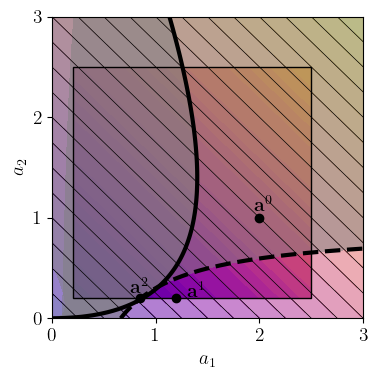

In [7]:
a2 = torch.tensor([0.85, 0.2])
g_1 = CONLIN(g, a1, a)

# Base plot
plot_contours(a, f(a), figsize=(4.0, 4.0), box=[a_lower, a_upper])

# Original constraint
plt.contour(a_1, a_2, g(a), [0], colors="k", linewidths=3)
plt.contourf(a_1, a_2, g(a), [0, 1], colors="gray", alpha=0.5)

# Approximated constraint
plt.contour(a_1, a_2, g_1, [0], colors="k", linewidths=3, linestyles="--")
plt.contourf(a_1, a_2, g_1, [0, 1], colors="gray", alpha=0.5)

# Points
plt.plot([a0[0]], [a0[1]], "o", color="black")
plt.annotate("$\mathbf{a}^0$", (1.95, 1.07), color="black")
plt.plot([a1[0]], [a1[1]], "o", color="black")
plt.annotate("$\mathbf{a}^1$", (1.3, 0.21), color="black")
plt.plot([a2[0]], [a2[1]], "o", color="black")
plt.annotate("$\mathbf{a}^2$", (0.75, 0.25), color="black")

# Styling
plt.xlabel("$a_1$")
plt.ylabel("$a_2$")
plt.xticks([0, 1, 2, 3])
plt.yticks([0, 1, 2, 3])
plt.tight_layout()
plt.savefig("../figures/four_bar_example_1.svg", transparent=True)
plt.plot()

# Example 25: MMA
Consider the previous example with the optimization problem
$$ \min_{\mathbf{a}}    \quad  f(\mathbf{a})= a_1 + a_2 $$
$$ \textrm{s.t.}        \quad  g(\mathbf{a}) = \frac{8}{16a_1+9a_2} - \frac{4.5}{9a_1+16a_2} -0.1 \le 0  $$
$$                      \quad  \mathbf{a} \in [0.2,2.5]^2$$

In [8]:
# Define the MMA approximation
def MMA(func, a_k, L_k, U_k, a):
    a_lin = a_k.clone().requires_grad_()
    grads = torch.autograd.grad(func(a_lin), a_lin)[0]
    neg_grad = grads < 0.0
    pos_grad = ~neg_grad
    p = torch.zeros_like(grads)
    p[pos_grad] = (U_k[pos_grad] - a_k[pos_grad]) ** 2 * grads[pos_grad]
    q = torch.zeros_like(grads)
    q[neg_grad] = -((a_k[neg_grad] - L_k[neg_grad]) ** 2) * grads[neg_grad]
    return (func(a_k) - torch.sum(p / (U_k - a_k) + q / (a_k - L_k))) * torch.ones_like(
        a[..., 0]
    ) + torch.sum(p / (U_k - a[..., :]) + q / (a[..., :] - L_k), dim=-1)

A MMA approximation at $\mathbf{a}^0=(2,1)^\top$ is illustrated in the following image with the dashed line for $s_0=0.2$. 

[]

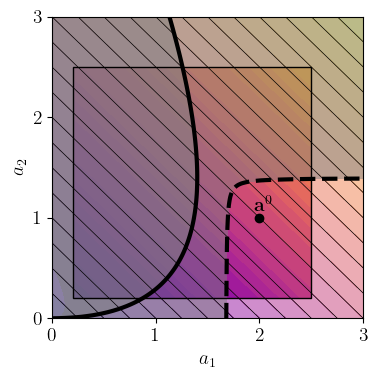

In [9]:
# Compute initial asymptotes
s0 = 0.2
L_0 = a0 - s0 * (a_upper - a_lower)
U_0 = a0 + s0 * (a_upper - a_lower)

# Compute approximation (and eliminate some artifacts)
g_0 = MMA(g, a0, L_0, U_0, a)
g_0[a[..., 0] < L_0[0]] = 1.0
g_0[a[..., 1] > U_0[1]] = 1.0

# Base plot
plot_contours(a, f(a), figsize=(4.0, 4.0), box=[a_lower, a_upper])

# Original constraint
plt.contour(a_1, a_2, g(a), [0], colors="k", linewidths=3)
plt.contourf(a_1, a_2, g(a), [0, 1], colors="gray", alpha=0.5)

# Approximated constraint
plt.contour(a_1, a_2, g_0, [0], colors="k", linewidths=3, linestyles="--")
plt.contourf(a_1, a_2, g_0, [0, 10], colors="gray", alpha=0.5)

# Points
plt.plot([a0[0]], [a0[1]], "o", color="black")
plt.annotate("$\mathbf{a}^0$", (1.95, 1.07), color="black")

# Styling
plt.xlabel("$a_1$")
plt.ylabel("$a_2$")
plt.xticks([0, 1, 2, 3])
plt.yticks([0, 1, 2, 3])
plt.tight_layout()
plt.savefig("../figures/four_bar_example_mma_0.svg", transparent=True)
plt.plot()

If we chose $s_0=0.5$, we get a less conservative approximation, as shown in the next image. This results in faster convergence, as an optimization of the convex problem gets closer to the optimum in a single step.

[]

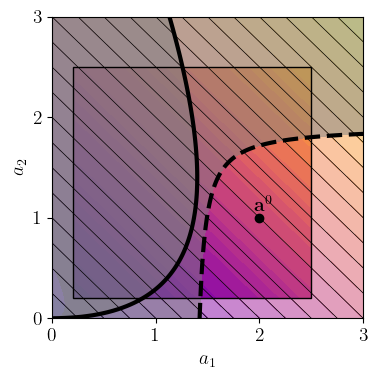

In [10]:
# Compute initial asymptotes
s0 = 0.5
L_0 = a0 - s0 * (a_upper - a_lower)
U_0 = a0 + s0 * (a_upper - a_lower)

# Compute approximation (and eliminate some artifacts)
g_0 = MMA(g, a0, L_0, U_0, a)
g_0[a[..., 0] < L_0[0]] = 1.0
g_0[a[..., 1] > U_0[1]] = 1.0

# Base plot
plot_contours(a, f(a), figsize=(4.0, 4.0), box=[a_lower, a_upper])

# Original constraint
plt.contour(a_1, a_2, g(a), [0], colors="k", linewidths=3)
plt.contourf(a_1, a_2, g(a), [0, 1], colors="gray", alpha=0.5)

# Approximated constraint
plt.contour(a_1, a_2, g_0, [0], colors="k", linewidths=3, linestyles="--")
plt.contourf(a_1, a_2, g_0, [0, 10], colors="gray", alpha=0.5)

# Points
plt.plot([a0[0]], [a0[1]], "o", color="black")
plt.annotate("$\mathbf{a}^0$", (1.95, 1.07), color="black")

# Styling
plt.xlabel("$a_1$")
plt.ylabel("$a_2$")
plt.xticks([0, 1, 2, 3])
plt.yticks([0, 1, 2, 3])
plt.tight_layout()
plt.savefig("../figures/four_bar_example_mma_1.svg", transparent=True)
plt.plot()